## Код для анализа и проверки параметра Хаббла различных моделей



In [6]:
import os  # Работа с путями и файловой системой
import numpy as np  # Работа с массивами и численные методы
import matplotlib.pyplot as plt  # Построение графиков
import pandas as pd  # Обработка и анализ табличных данных
from math import sqrt, pow, log  # Математические функции: корень, степень, логарифм
import matplotlib.cm as cm  # Цветовые схемы (colormaps) для визуализаций
from scipy.integrate import quad  # Численное интегрирование функций
from cobaya.run import run  # Запуск модели с помощью cobaya (MCMC, nested sampling и др.)
from getdist.mcsamples import MCSamplesFromCobaya  # Преобразование результата cobaya в объект GetDist
import getdist.plots as gdplt  # Визуализация результатов: угловые графики и пр.

# === Настройки графиков ===
# Установка стандартного размера всех графиков
plt.rcParams["figure.figsize"] = (20, 18)

# Путь к пользовательскому стилю оформления графиков
# Предполагается, что файл 'standard.mplstyle' лежит рядом с ноутбуком
custom_style_path = os.path.join(os.getcwd(), 'standard.mplstyle')

# Попытка применить стиль, если файл найден
if os.path.exists(custom_style_path):
    plt.style.use(custom_style_path)
else:
    print("Файл стиля 'standard.mplstyle' не найден. Используется стиль по умолчанию.")

In [7]:
# === Загрузка и предварительная обработка данных Pantheon+ SH0ES ===

# Пути к данным (предполагается, что файлы лежат в той же папке, что и ноутбук)
data_file = os.path.join(os.getcwd(), "Pantheon+SH0ES.dat")
cov_file = os.path.join(os.getcwd(), "Pantheon+SH0ES_STAT+SYS.cov")

# Загружаем таблицу с суперновыми
# sep="\s+" означает, что столбцы разделены пробелами или табами
SNdata = pd.read_table(data_file, sep=r"\s+")
# Сортируем данные по космологическому красному смещению zHD
SNdata = SNdata.sort_values(by=["zHD"])
# Извлекаем необходимые столбцы и преобразуем их в массивы NumPy
zSNe = SNdata["zHD"].to_numpy()         # Космологическое красное смещение
zhel = SNdata["zHEL"].to_numpy()        # Гелиоцентрическое красное смещение
muobs = SNdata["MU_SH0ES"].to_numpy()   # Модуль расстояния (наблюдаемый)

# Файл с ковариационной матрицей был сохранён как CSV в виде одного столбца (сплюснутая матрица 1701×1701)
InverseCmat_aux = pd.read_csv(cov_file)
# Восстанавливаем двумерную обратную ковариационную матрицу размером 1701×1701
n = 1701
InverseCmat = [
    InverseCmat_aux['1701'][i*n:(i+1)*n].to_numpy()
    for i in range(n)]
# Преобразуем в NumPy-массив
Cinverse = np.array(InverseCmat)
# Получаем прямую (обычную) ковариационную матрицу из обратной
Cmat = np.linalg.inv(Cinverse)
# Извлекаем диагональные элементы из обратной матрицы: это элементы диагональной статистической ошибки
Dstatinverse = np.diag(Cinverse)
# Вычисляем стандартные отклонения из диагонали обычной ковариационной матрицы
Dstat = np.sqrt(np.diag(Cmat))

In [8]:
# === Параметры для Байесовского анализа ===
sampl = 10000  # Количество выборок в MCMC (или другом методе)
par = 5        # Количество параметров модели
# sampl = par * 2000 - минимально необходимое количество (увеличить в 2 раза для финальной точности)

# Стандартные отклонения для начальных значений параметров (используются в sampling)
# Примерно на порядок ниже предполагаемого значения величины
sigma_omega_m = 0.01
sigma_omega_s = 1
sigma_V0      = 0.1
sigma_phi_1   = 0.01
sigma_H0      = 1.0

# === Предварительное выделение массивов (если потребуется для визуализаций) ===

dmthSN    = np.zeros(len(zSNe))  # Теоретические значения модуля расстояния
dlthSN    = np.zeros(len(zSNe))  # Теоретические значения светового расстояния
dldataSN  = np.zeros(len(zSNe))  # Наблюдаемые значения светового расстояния
error     = np.zeros(len(zSNe))  # Ошибки
dlerror   = np.zeros(len(zSNe))  # Ошибки по световому расстоянию
ckm = 299792.458  # Скорость света в км/с

# === Интегрируемая функция: 1 / H(z) ===
def integrand(x, omega_s, omega_m, V0, phi_1, H0):
    Ez2 = omega_s * 10**(-23) * (1 + x)**6 + omega_m * (1 + x)**3 + V0 + phi_1
    return 1.0 / (H0 * np.sqrt(Ez2))

# === Байесовская логарифмическая функция правдоподобия ===

def lnlps(omega_s, omega_m, V0, phi_1, H0):
    # Физические ограничения на параметры
    if (
        omega_s < 0.0 or omega_m < 0.0 or V0 < 0.0 or phi_1 < 0.0 or H0 < 0.0 or
        (omega_s*(10**(-23)) + omega_m + V0 + phi_1 > 1.0)
    ):
        return -1e100  # Очень малое значение логарифма правдоподобия

    # Численное интегрирование для каждого z: получаем d_L
    d_parSNe = np.zeros(len(zSNe))  # Предварительно выделяем память
    for idx, z in enumerate(zSNe):
        integral, error_estimate = quad(integrand, 0, z, args=(omega_s, omega_m, V0, phi_1, H0))
        d_parSNe[idx] = integral
    # Световое расстояние: d_L = (1 + z_hel) * c * \int dz / H(z)
    coefSNe = ckm * (1 + zhel)
    dSNe = coefSNe * d_parSNe  # Световое расстояние в Мпк
    # Вычисление модуля расстояния (log10)
    logdl_thSNe = np.log10(dSNe)
    muthSNe = 5 * logdl_thSNe + 25
    # Разность наблюдаемых и теоретических величин
    Deltamu = muobs - muthSNe
    # Статистика χ² с учетом полной ковариационной матрицы
    chi2_SNe = np.dot(Deltamu, np.dot(Cinverse, Deltamu))
    # Логарифм правдоподобия
    loglikely = -0.5 * chi2_SNe
    return loglikely

In [4]:
# === Подключаем логарифм функции правдоподобия к системе Cobaya ===
info_PS = {"likelihood": {"agostini": lnlps}}
# Пользовательская функция логарифма правдоподобия

# === Задаем параметры модели и их приоры в виде OrderedDict ===
from collections import OrderedDict as odict
info_PS["params"] = odict([
    ["omega_m", {
        "prior": { "dist": "uniform", "min": 0.2, "max": 0.4 },  # Минимум-максимум
        "ref": 0.3,                 # Стартовая (референсная) точка
        "latex": r"\Omega_m",       # Обозначение для графиков
        "proposal": 0.01            # Шаг проб в цепочке
    }],
    ["omega_s", {
        "prior": { "dist": "uniform", "min": 3, "max": 7 },
        "ref": 5,
        "latex": r"\Omega_s",
        "proposal": 1
    }],
    ["H0", {
        "prior": { "dist": "uniform", "min": 60.0, "max": 80.0 }, 
        "ref": 70.0,
        "latex": r"H_0",
        "proposal": 0.1
    }],
    ["V0", {
        "prior": { "dist": "uniform", "min": 0.6, "max": 0.8 },
        "ref": 0.7,
        "latex": r"V_0",
        "proposal": 0.1
    }],
    ["phi_1", {
        "prior": { "dist": "uniform", "min": 0.0, "max": 0.1 },
        "ref": 0.05,
        "latex": r"\phi_1",
        "proposal": 0.001
    }]])

# === Настройки MCMC-сэмплера Cobaya ===
info_PS["sampler"] = {
    "mcmc": {
        "burn_in": 300,              # Длина прогорания
        "max_samples": 1000000,      # Максимум выборок
        "Rminus1_stop": 0.1,         # Условие остановки по Gelman–Rubin
        "Rminus1_cl_stop": 0.1,
        "learn_proposal": True       # Автоматическая подстройка предложений
    }}

# === Запуск анализа ===
updated_info_PS, sampler_PS = run(info_PS)

# Время выполнения для данного примера: ~7.5 минут (можно уменьшить через max_samples или proposal)

[agostini] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: omega_m:0.3, omega_s:5, H0:70, V0:0.7, phi_1:0.05
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {agostini: 245000.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2025-05-13 17:30:00 : 1 steps taken -- still burning in, 301 accepted steps left.
[mcmc] Finished burn-in phase: discarded 300 accepted steps.
[mcmc] Learn + convergence test @ 200 samples accepted.
[mcmc]  - Acceptance rate: 0.232
[mcmc]  - Convergence of means: R-1 = 12.780780 after 160 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 400 samples accepted.
[mcmc]  - Acceptance rat

Средние значения и 1σ интервалы в формате LaTeX:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

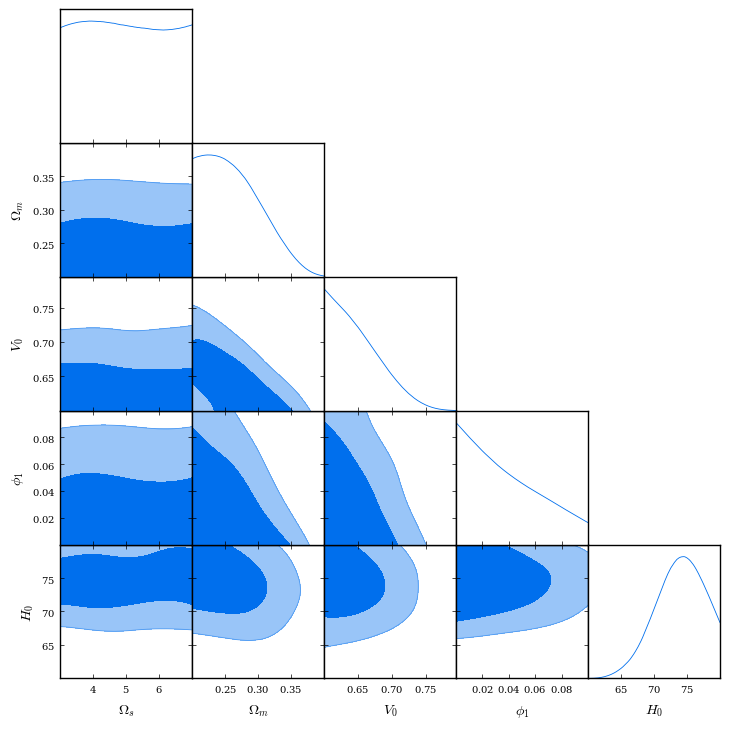

In [5]:
gdsamples_PS = MCSamplesFromCobaya(updated_info_PS, sampler_PS.products()["sample"], ignore_rows=0.2)
gdplot = gdplt.getSubplotPlotter(width_inch=8)

plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'

param_labels = [r'$\Omega_s$', r'$\Omega_m$', r'$V_0$', r'$\phi_1$', r'$H_0$']
gdplot.triangle_plot(gdsamples_PS, ["omega_s", "omega_m", "V0", "phi_1", "H0"], filled=True, title_limit_1d=True)
mean = gdsamples_PS.getMeans()[:5]
sigma = np.sqrt(np.array(gdsamples_PS.getVars()[:5]))
covmat = gdsamples_PS.getCovMat().matrix[:5, :5]

plt.savefig("HubblePantheon+SH0ES.pdf", format="pdf", bbox_inches="tight")

from IPython.display import display, Math

param_names = [r'\Omega_m', r'\Omega_s \times 10^{-23}', r'H_0', r'V_0', r'\phi_1']
print("Средние значения и 1σ интервалы в формате LaTeX:")
for i in range(len(mean)):
    expression = r"${0} = {1:.4f} \pm {2:.4f}$".format(param_names[i], mean[i], sigma[i])
    display(Math(expression))